In [1]:
import pylab
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import yeojohnson
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

%matplotlib inline

## Nifty index values for a year during the 2008 financial crisis

In [2]:
data = pd.read_csv("2008 Great Recession.csv")
print("Nifty range between 21 Apr 2008 to 4 May 2009")
data.head(5)

Nifty range between 21 Apr 2008 to 4 May 2009


,Date,Price,Open,High,Low,Volume,Chg%
0,21-Apr-08,5037.00,4955.90,5053.40,4955.90,110.42M,1.59%
1,22-Apr-08,5049.30,5037.05,5074.25,4994.05,126.75M,0.24%
2,23-Apr-08,5022.80,5044.35,5083.50,5003.55,144.56M,-0.52%
3,24-Apr-08,4999.85,5022.90,5072.70,4991.35,154.29M,-0.46%
4,25-Apr-08,5111.70,4999.15,5117.70,4999.15,134.45M,2.24%


In [3]:
# Calculating log return of index
data["LogReturn"] = np.log(data["Price"]).shift(-1) - np.log(data["Price"])
data.dropna(inplace=True)
print("Number of rows: {}".format(data.shape[0]))
data.head(5)

Number of rows: 248


,Date,Price,Open,High,Low,Volume,Chg%,LogReturn
0,21-Apr-08,5037.00,4955.90,5053.40,4955.90,110.42M,1.59%,0.002439
1,22-Apr-08,5049.30,5037.05,5074.25,4994.05,126.75M,0.24%,-0.005262
2,23-Apr-08,5022.80,5044.35,5083.50,5003.55,144.56M,-0.52%,-0.004580
3,24-Apr-08,4999.85,5022.90,5072.70,4991.35,154.29M,-0.46%,0.022124
4,25-Apr-08,5111.70,4999.15,5117.70,4999.15,134.45M,2.24%,-0.004323


## Distribution of Index log-returns

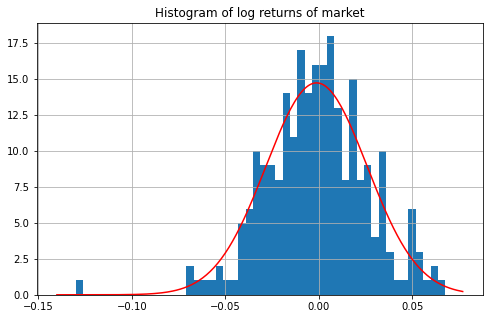

In [4]:
mu = data['LogReturn'].mean()
sigma = data['LogReturn'].std(ddof=1)

density = pd.DataFrame()
density['x'] = np.arange(data['LogReturn'].min()-0.01, data['LogReturn'].max()+0.01, 0.001)
density['pdf'] = norm.pdf(density['x'], mu, sigma)

data['LogReturn'].hist(bins=50, figsize=(8, 5))
plt.plot(density['x'], density['pdf'], color='red')
plt.title("Histogram of log returns of market")
plt.show()

## Checks for normality of distribution

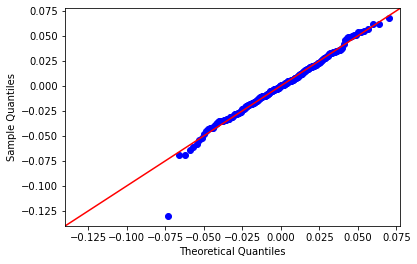

In [5]:
# QQ plot
qqplot(data["LogReturn"], loc=mu, scale=sigma, line="45")
plt.show()

In [6]:
# Shapiro Wilk normality test
# H0: Distribution is normal

stat, p = shapiro(data["LogReturn"])
print("Statistics = {:.3f}, p = {:.3f}".format(stat, p))
alpha = 0.05
if p > alpha:
    print("Sample looks normal distributed (do not reject H0)")
else:
    print("Sample does not look normally distributed (reject H0)")

Statistics = 0.983, p = 0.005
Sample does not look normally distributed (reject H0)


In [7]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
# Normality test based on D’Agostino and Pearson’s test

k2, p = normaltest(data["LogReturn"])
print("p = {}".format(p))
alpha = 0.05
if p > alpha:
    print("Sample looks normal distributed (do not reject H0)")
else:
    print("Sample does not look normally distributed (reject H0)")

p = 0.00039517085579976127
Sample does not look normally distributed (reject H0)


**The distribution does not seem to be distributed normally. Hence, I have now tried some transformation to try to fit into normal distribution**

## Data transformation to fit normal distribution

**Yeo Johnson** transformation to fit to normal distribution ([https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.yeojohnson.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.yeojohnson.html))

In [8]:
# Yeo Johnson transformation to fit to normal distribution
xt, lmbda_opt = yeojohnson(data["LogReturn"])
mu_n = xt.mean()
sigma_n = xt.std(ddof=1)

In [9]:
# Difference between original log returns and transformed values
temp = pd.DataFrame(data["LogReturn"])
temp["After transformation"] = pd.Series(xt)
temp.head()

,LogReturn,After transformation
0,0.002439,0.002447
1,-0.005262,-0.005224
2,-0.004580,-0.004551
3,0.022124,0.022814
4,-0.004323,-0.004297


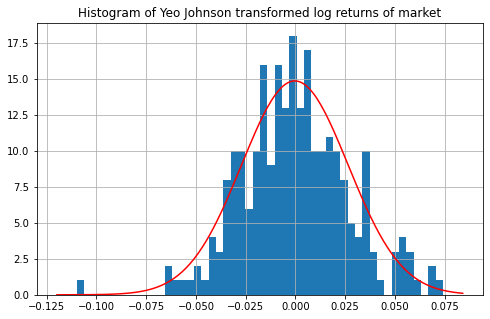

In [10]:
mu = xt.mean()
sigma = xt.std(ddof=1)

density = pd.DataFrame()
density['x'] = np.arange(xt.min()-0.01, xt.max()+0.01, 0.001)
density['pdf'] = norm.pdf(density['x'], mu, sigma)

pd.Series(xt).hist(bins=50, figsize=(8, 5))
plt.plot(density['x'], density['pdf'], color='red')
plt.title("Histogram of Yeo Johnson transformed log returns of market")
plt.show()

## Check for normality after transformation

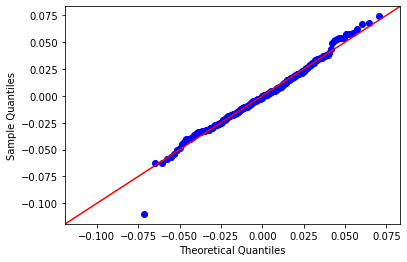

In [11]:
# QQ plot after Yeo Johnson transformation
qqplot(xt, loc=mu_n, scale=sigma_n, line="45")
plt.show()

In [12]:
# Shapiro Wilk test
# H0: Distribution is normal

stat, p = shapiro(xt)
print("Statistics = {:.3f}, p = {:.3f}".format(stat, p))
alpha = 0.05
if p > alpha:
    print("Sample looks normal distributed (do not reject H0)")
else:
    print("Sample does not look normally distributed (reject H0)")

Statistics = 0.989, p = 0.057
Sample looks normal distributed (do not reject H0)


In [13]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
# Normality test based on D’Agostino and Pearson’s test

k2, p = normaltest(xt)
print("p = {}".format(p))
alpha = 0.05
if p > alpha:
    print("Sample looks normal distributed (do not reject H0)")
else:
    print("Sample does not look normally distributed (reject H0)")

p = 0.09119230260435833
Sample looks normal distributed (do not reject H0)


**After the transformation, the data now seems to be normally distributed**

## Probabilities of losses, 5% VaR

In [14]:
# probability that the stock price of microsoft will drop over 5% in a day
prob_return1 = norm.cdf(-0.05, mu_n, sigma_n)
print("The Probability is {:.5f}".format(prob_return1))

The Probability is 0.03196


In [15]:
# probability that the stock price of microsoft will drop over 10% in a day
prob_return1 = norm.cdf(-0.10, mu_n, sigma_n)
print("The Probability is {:.5f}".format(prob_return1))

The Probability is 0.00010


In [16]:
# drop over 40% in 248 days
mu248 = 248*mu_n
sigma248 = (248**0.5) * sigma_n
print("The probability of dropping over 40% in 248 days is {:.5f}".format(norm.cdf(-0.4, mu248, sigma248)))

The probability of dropping over 40% in 248 days is 0.22070


In [17]:
# drop over 20% in 248 days
mu248 = 248*mu_n
sigma248 = (248**0.5) * sigma_n
print("The probability of dropping over 20% in 248 days is {:.5f}".format(norm.cdf(-0.2, mu248, sigma248)))

The probability of dropping over 20% in 248 days is 0.38347


In [18]:
# 1-day 5% Value at Risk (VaR)
print("1-day 5% Value at Risk (VaR): {:.2f}%".format(norm.ppf(0.05, mu_n, sigma_n)*100))

1-day 5% Value at Risk (VaR): -4.44%
